In [175]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq, irfft
from math import pi
from matplotlib.patches import Polygon

In [195]:
class Signal():
    def __init__(self, E, params):
        self.unpack_params(params)
        self.check_params()
        self.t_org, self.E_org = self.get_original_signal(E)
        self.t, self.E = self.interpolate()
        self.pad()
        self.freq, self.E_f, self.E_f_abs, self.df = self.get_fourier()
        self.bandwidth, self.bb_freq = self.get_broadband()
        
    def unpack_params(self, params):
        for key in params:
            exec(f"self.{key} = params[key]")
    
    def check_params(self):
        if type(self.n_interpol) != int:
            raise ValueError(f"Number of interpolation points must be type int, but given type is {type(self.n_interpol)}")
        elif self.n_interpol < 0:
             raise ValueError("Number of interpolation points cant be negative")
        if self.padfactor < 0:
            raise ValueError(f"Padding can't be negative, but given value is {self.P}")
        if self.dt < 0:
            raise ValueError(f"Timestep can't be negative, but given value is {self.dt}")
        if type(self.bb_fraction) != int:
            raise ValueError("bb_fraction must be a list of positive numbers")

    def get_original_signal(self, E):
        t = np.linspace(0, len(E)*self.dt, len(E))
        return t, E

    def interpolate(self):
        t_pol = np.linspace(0, len(self.E_org)*self.dt, len(self.E_org)*(self.n_interpol +1))
        E_pol = np.interp(t_pol, self.t_org, self.E_org)
        self.dt /= (1+self.n_interpol)
        return t_pol, E_pol

    def pad(self):
        E = self.E.copy()
        N = len(E)
        pad_points = self.padfactor * N
        i_max, i_min = np.argmax(E), np.argmin(E)
        i_mid = (i_max + i_min)//2
        left_pad = 0
        right_pad = 0
        peak_to_left = i_mid < N/2

        if pad_points < abs(N-2*i_mid):
            print("WOO")
            if peak_to_left:
                left_pad += pad_points
            else:
                right_pad += pad_points
            pad_points = 0
        else:

            if peak_to_left:
                pad_points -= (N - 2*i_mid)
                left_pad += (N - 2*i_mid)
            else:
                pad_points -= (2*i_mid - N)
                right_pad += (2*i_mid - N)

        right_pad += pad_points//2
        left_pad += pad_points//2

        self.E = np.concatenate((np.zeros(left_pad), E, np.zeros(right_pad)))
        self.t = np.linspace(0, len(self.E)*self.dt, len(self.E))

    def get_fourier(self):
        E_f = rfft(self.E)
        E_f_abs = np.abs(E_f)
        freq = rfftfreq(len(self.E), d = self.dt)*1000
        df = freq[1] - freq[0]
        return freq, E_f, E_f_abs, df

    def get_broadband(self):
        E_f_max = np.amax(self.E_f_abs)
        bb_index  = np.argwhere(self.E_f_abs > E_f_max/self.bb_fraction).flatten()
        # print(bb_index)
        # raise ValueError()
        i_min, i_max =  bb_index[[1,-1]]
        fmin, fmax = self.freq[[i_min, i_max]]
        delta_f = fmax - fmin
        bb_freq = (i_min, i_max, fmin, fmax)
        return delta_f, bb_freq
        
    def plot_fourier(self):
        plt.figure()
        plt.plot(self.freq, self.E_f_abs)
        plt.xscale("log")
        plt.yscale("log")

    def plot_signal(self, figpath = "None"):
        fig, ax = plt.subplots()
        ax.plot(self.t_org, self.E_org)
        ax.set_xlabel("Time [fs]")
        ax.set_ylabel("E-field [N/C]")
        ax.set_title("Transient Signal")

        if figpath != "None":
            if figpath[-4:] != ".png":
                figpath += ".png"
            fig.savefig(figpath)
        
    def plot_bb(self, figpath = "None"):

        f_margin = 10
        i_min, i_max = self.bb_freq[0], self.bb_freq[1]
        plot_min = i_min - f_margin if i_min > f_margin else 0
        plot_max = i_max + f_margin if (i_max + f_margin) < len(self.freq) else len(self.freq)

        fill_f = self.freq[i_min:i_max+1].copy()
        fill_E = self.E_f_abs[i_min:i_max+1].copy()
        low_bound = 1/self.bb_fraction
        verts = [(fill_f[0], low_bound), *zip(fill_f, fill_E), (fill_f[-1], low_bound)]
        poly = Polygon(verts, facecolor = "springgreen")
        
        fig, ax = plt.subplots()
        ax.add_patch(poly)
        ax.plot(self.freq[plot_min:plot_max], self.E_f_abs[plot_min:plot_max])
        ax.set_xlabel("Frequency [THz]")
        ax.set_ylabel("E-field [N/C]")
        ax.set_title("Frequency Spectra")
        text_x = (self.freq[i_min] * 2 + self.freq[i_max]) / 3
        text_y = np.amax(self.E_f_abs)/3
        ax.text(text_x, text_y, f"Bandwidth: {self.bandwidth} THz", ha = "center", fontsize = 12)
       

        if figpath != "None":
            if figpath[-4:] != ".png":
                figpath += ".png"
            fig.savefig(figpath)

    def export_data(self, folderpath):
        signal = self.E_org.copy()




    

[0.  0.1 0.2 0.3 0.4] [ 999.6  999.7  999.8  999.9 1000. ]


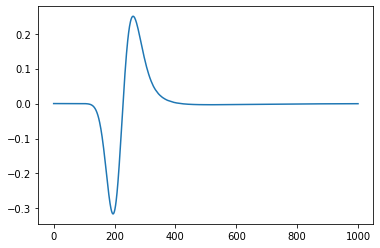

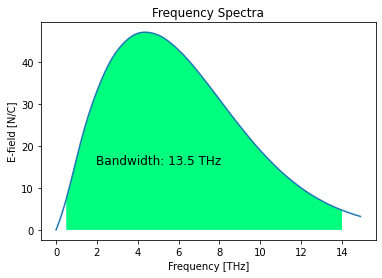

In [196]:
# Signal extraction + interpolation

E = np.loadtxt("../testsave copy.out")
E = E[:,-1].flatten()
params = {"padfactor":9, "n_interpol":1, "dt":1, "bb_fraction": 10}

S = Signal(E,params)
# S.plot_fourier()
S.plot_signal()
S.plot_bb()
print(S.freq[:5], S.freq[-5:])


# print(s.padfactor)
# print(s.bb_factors)
# print(s.dt)
# print(s.n_interpol)

3.0
6.500000000000001
4.666666666666666
65.49075030449545
0.08886688240494153


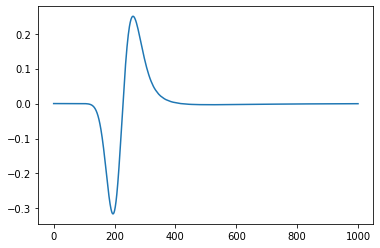

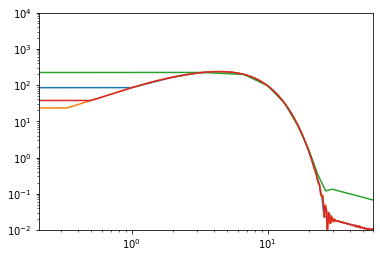

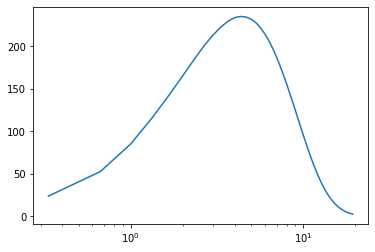

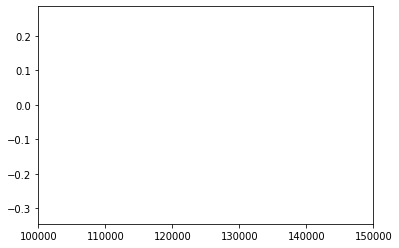

In [178]:
E = np.loadtxt("../testsave copy.out")
E = E[:,-1].flatten()
t = np.arange(len(E))

n_interpol = 10
t_interpol = np.linspace(0, len(t), len(t)*n_interpol)
E_interpol = np.interp(t_interpol, t, E)
N = len(E_interpol)
E_fourier = rfft(E_interpol)
freq = rfftfreq(N, d = 1/n_interpol)*1000

E_trunc = E_interpol[100*n_interpol:-600*n_interpol]
t_trunc = t_interpol[100*n_interpol:-600*n_interpol]
N_trunc = len(E_trunc)
E_fourier_trunc = rfft(E_trunc)
freq_trunc = rfftfreq(N_trunc, d = 1/n_interpol)*1000

E_padded = np.concatenate((np.ones(N//2)*E_interpol[0], E_interpol, np.ones(N//2)*E_interpol[-1]))
t_padded = np.concatenate((np.linspace(-N/(2*n_interpol),-1/n_interpol, N//2), 
                           t_interpol, np.linspace((N+1)/n_interpol, 3*N//(2*n_interpol),N//2)))
N_padded = len(E_padded)
E_fourier_padded = rfft(E_padded)
freq_padded = rfftfreq(N_padded, d=1/n_interpol)*1000

# E_padded2 = np.concatenate((np.ones(N)*E_interpol[0], E_interpol, np.ones(N)*E_interpol[-1]))
E_padded2 = np.concatenate((np.zeros(N), E_interpol, np.zeros(N)))
t_padded2 = np.concatenate((np.linspace(-N/(n_interpol),-1/n_interpol, N), 
                           t_interpol, np.linspace((N+1)/n_interpol, 3*N//(n_interpol),N)))
N_padded2 = len(E_padded2)
E_fourier_padded2 = rfft(E_padded2)
freq_padded2 = rfftfreq(N_padded2, d=1/n_interpol)*1000



# print(freq[:5])
# print(freq_trunc[:5])
# print(freq_padded[:5])

# print(len(E_interpol), len(t_interpol))
# print(len(E_trunc), len(t_trunc))
# print(len(E_padded), len(t_padded))

plt.figure()
plt.plot(t_interpol, E_interpol)
# N = E_interpol.shape[0]
# freq = rfftfreq(N, d = 1/n_interpol)*1000/(2*pi)

plt.figure()
plt.plot(freq, np.abs(E_fourier))
plt.plot(freq_padded2, np.abs(E_fourier_padded2))
plt.plot(freq_trunc, np.abs(E_fourier_trunc))
plt.plot(freq_padded, np.abs(E_fourier_padded))
plt.yscale("log")
plt.xscale("log")
plt.xlim(None, 60)
plt.ylim(0.01, 10000)

# plt.figure()
# plt.plot(freq_trunc, np.abs(E_fourier_trunc))
# plt.yscale("log")
# plt.xscale("log")
# plt.xlim(None, 60)
# plt.ylim(0.01, 10000)

# plt.figure()
# plt.plot(freq_padded, np.abs(E_fourier_padded))
# plt.yscale("log")
# plt.xscale("log")
# plt.xlim(None, 60)
# plt.ylim(0.01, 10000)

# plt.figure()
# plt.plot(freq_padded2, np.abs(E_fourier_padded2))
# plt.yscale("log")
# plt.xscale("log")
# plt.xlim(None, 60)
# plt.ylim(0.01, 10000)


# plt.figure()
# plt.plot(t[100:500],E[100:500])

print(freq[np.argmax(E_fourier)])
print(freq_padded[np.argmax(E_fourier_padded)])
print(freq_padded2[np.argmax(E_fourier_padded2)])

m = np.amax(E_fourier_padded)
ind = np.argwhere(np.abs(E_fourier_padded2) > m/100)
ind2 = np.argwhere(np.abs(E_fourier_padded2) <= m/10)
E_f_new, freq_new = E_fourier_padded2[ind], freq_padded2[ind]
E_f_new2 = E_fourier_padded2.copy()
E_f_new2[ind2] = 0
# print(freq_new)

# print(E_f_new)
# print(E_fourier_padded2)
E_new = irfft(E_f_new2.flatten())



plt.figure()
plt.plot(freq_new, np.abs(E_f_new))
plt.xscale("log")

plt.figure()
plt.plot(E_new, 'r')
plt.plot(E_padded2, 'b')
plt.xlim(100000, 150000)


power = np.trapz(np.square(E_padded2))
power_diff = np.trapz(np.square(E_padded2 - E_new))

print(power)
print(power_diff)


# print(freq[:5])
# print(len(freq))
# # plt.figure()
# # plt.plot(t_interpol, E_interpol)
# # print(len(t_interpol))
# print(t_interpol[-1])

In [179]:
x = np.arange(10)
# condlist = [x<3, x<]
choicelist = [x, x**2]
print(condlist)
print(choicelist)
np.select(condlist, choicelist)

NameError: name 'condlist' is not defined

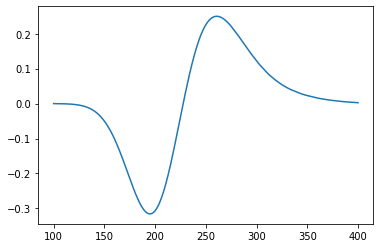

In [ ]:
E_new = irfft(E_fourier)
plt.plot(t_interpol, E_new)
plt.show()

[0.         0.33333333 0.66666667 1.         1.33333333]
1501


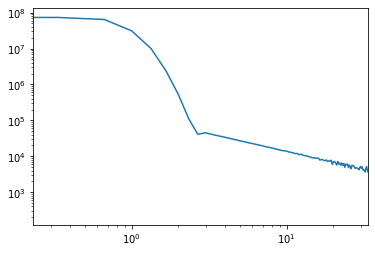

In [ ]:
E_fourier = np.abs(np.fft.rfft(E_interpol))
freq = np.fft.rfftfreq(E_interpol.shape[0], d = 1)

plt.plot(freq, E_fourier)
plt.yscale("log")
plt.xscale("log")
plt.xlim(None, freq[100])
print(freq[:5])
print(len(freq))
# for i, (amp, f) in enumerate(zip(E_fourier, freq)):

In [ ]:
E_fourier = rfft((E_trunc))
freq = np.fft.rfftfreq(E_trunc.shape[0], d = n_interpol)

print(freq.shape)
plt.yscale("log")
# for i, (amp, f) in enumerate(zip(E_fourier, freq)):
    